Cell 1: Setup

In [6]:
# 1. Imports and setup
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Project root for module imports
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root added to sys.path:", project_root)

# MLflow
import mlflow
import mlflow.sklearn

# Module imports
from src.data_processing import split_data
from src.model_train import (
    train_logistic_regression,
    train_random_forest,
    evaluate_model,
    log_model_to_mlflow
)

Project root added to sys.path: D:\Personal\KAIM-10 Academy\Week 4\Project\Credit-Risk-Modeling-Week 4


Cell 2: Load Data

In [7]:
# Load processed data
data_path = os.path.join(project_root, "data", "processed", "rfm_model_ready.csv")
df = pd.read_csv(data_path)
print(f"Data shape: {df.shape}")
df.head()

Data shape: (3632, 7)


,CustomerId,Recency,Frequency,Monetary,HighRisk,Cluster,is_high_risk
0,CustomerId_1001,90,1,25200.0,1,2,1
1,CustomerId_1002,29,5,4500.0,0,0,0
2,CustomerId_1003,13,1,26000.0,0,0,0
3,CustomerId_1004,54,1,2000.0,1,2,1
4,CustomerId_1005,48,1,55000.0,1,2,1


Cell 3: Simple EDA to make sure the data's distribution and cleaning

In [17]:
# -------------------------------
# 1. Missing Values Check
# -------------------------------
print("Missing values per column:")
print(df.isnull().sum())

# 2. Summary statistics
print("\nSummary statistics:")
display(df.describe())

# ... rest of EDA code ...

Missing values per column:
CustomerId      0
Recency         0
Frequency       0
Monetary        0
HighRisk        0
Cluster         0
is_high_risk    0
dtype: int64

Summary statistics:


,Recency,Frequency,Monetary,HighRisk,Cluster,is_high_risk
count,3632.000000,3632.000000,3.632000e+03,3632.000000,3632.000000,3632.000000
mean,31.875275,5.734857,2.182810e+05,0.372247,0.830672,0.372247
std,26.933267,9.062099,2.137332e+06,0.483470,0.940953,0.483470
min,1.000000,1.000000,5.000000e+01,0.000000,0.000000,0.000000
25%,6.000000,1.000000,5.500000e+03,0.000000,0.000000,0.000000
50%,25.000000,2.000000,2.620000e+04,0.000000,0.000000,0.000000
75%,54.000000,6.000000,9.325000e+04,1.000000,2.000000,1.000000
max,91.000000,71.000000,8.346600e+07,1.000000,2.000000,1.000000



Value counts for HighRisk:
HighRisk
0    2280
1    1352
Name: count, dtype: int64

Value counts for Cluster:
Cluster
0    1967
2    1352
1     313
Name: count, dtype: int64

Value counts for is_high_risk:
is_high_risk
0    2280
1    1352
Name: count, dtype: int64


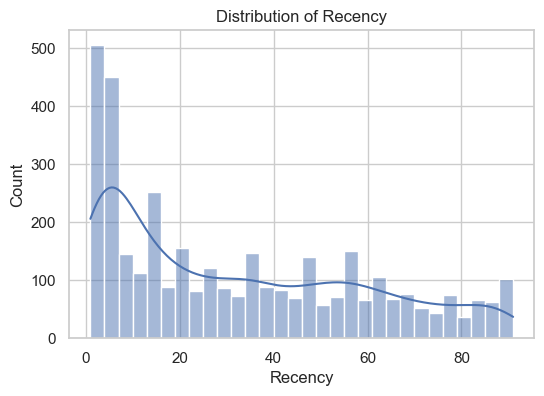

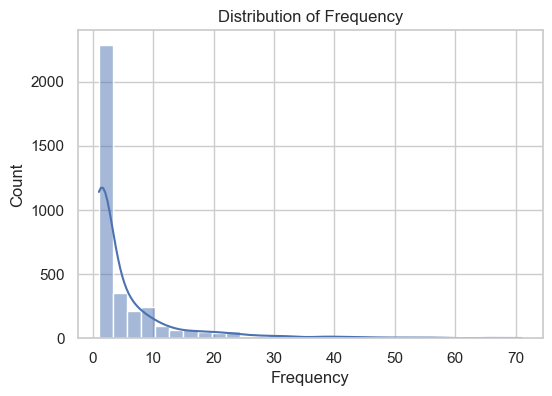

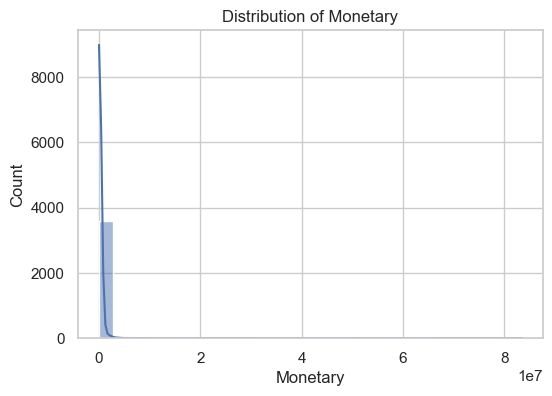

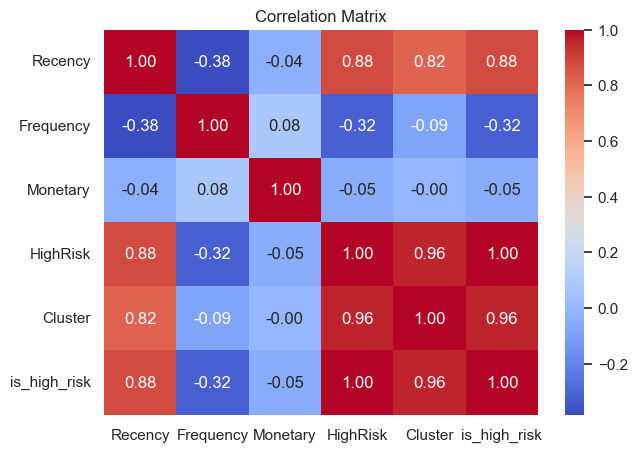

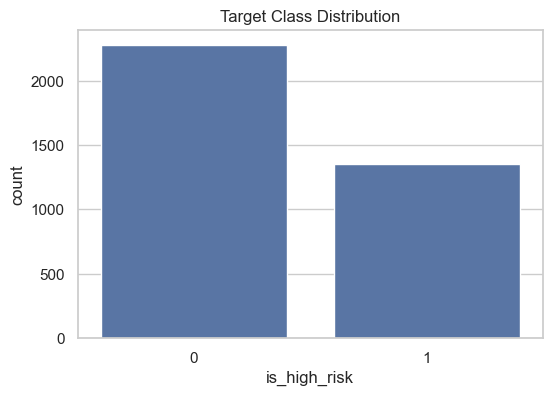

Step 1: Features and Target Separated ✅
X shape: (3632, 4), y shape: (3632,)

Step 2: Feature Types Identified ✅
Categorical: ['Cluster']
Numerical: ['Recency', 'Frequency', 'Monetary']
All features: ['Recency', 'Frequency', 'Monetary', 'Cluster']


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# -------------------------------
# 1. Value Counts for Categorical Columns
# -------------------------------
categorical_cols = ['HighRisk', 'Cluster', 'is_high_risk']
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

# -------------------------------
# 2. Distribution of Numeric Features
# -------------------------------
numeric_cols = ['Recency', 'Frequency', 'Monetary']
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# -------------------------------
# 3. Correlation Heatmap (numeric only)
# -------------------------------
plt.figure(figsize=(7,5))
sns.heatmap(df[numeric_cols + ['HighRisk', 'Cluster', 'is_high_risk']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# -------------------------------
# 4. Target Balance
# -------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='is_high_risk', data=df)
plt.title('Target Class Distribution')
plt.show()

# -------------------------------
# 5. Preprocessing Pipeline
# -------------------------------
# Identify categorical and numeric features
cat_features = ['HighRisk', 'Cluster']
num_features = ['Recency', 'Frequency', 'Monetary']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

# -------------------------------
# 6. Separate Features and Target
X = df.drop(columns=['CustomerId', 'is_high_risk', 'HighRisk'])  # Clean features
y = df['is_high_risk']  # Target to predict

print("Step 1: Features and Target Separated ✅")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# 7. Identify Feature type
cat_features = ['Cluster']  # Your categorical feature
num_features = ['Recency', 'Frequency', 'Monetary']  # Your numerical features

print("\nStep 2: Feature Types Identified ✅")
print(f"Categorical: {cat_features}")
print(f"Numerical: {num_features}")
print(f"All features: {list(X.columns)}")

Task 5: Data Preparation- Train/Test SPlit

In [22]:
# ============================================
# TASK 5.2: DATA PREPARATION - Train/Test Split
# ============================================

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# RE-DEFINE the feature lists based on CURRENT X columns
# X currently has: ['Recency', 'Frequency', 'Monetary', 'Cluster']
num_features = ['Recency', 'Frequency', 'Monetary']  # From X.columns
cat_features = ['Cluster']  # From X.columns

# RE-CREATE the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)
    ]
)

print("✅ Preprocessor redefined with current features:")
print(f"   Numerical: {num_features}")
print(f"   Categorical: {cat_features}")

# NOW apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\n✅ Preprocessing Applied Successfully!")
print(f"X_train processed shape: {X_train_processed.shape}")
print(f"X_test processed shape:  {X_test_processed.shape}")

✅ Preprocessor redefined with current features:
   Numerical: ['Recency', 'Frequency', 'Monetary']
   Categorical: ['Cluster']

✅ Preprocessing Applied Successfully!
X_train processed shape: (2542, 5)
X_test processed shape:  (1090, 5)


In [23]:
# ============================================
# TASK 5.2: SETUP FOR REPRODUCIBILITY
# ============================================

# GLOBAL RANDOM STATE - Set once, use everywhere
RANDOM_STATE = 42  # Task 5.2 requirement: "Ensure reproducibility by setting a random_state"

print(f"🔧 Random State set to: {RANDOM_STATE} (for reproducibility)")
print("=" * 60)

🔧 Random State set to: 42 (for reproducibility)


Task 5.3: Model Training with Reproducibility

In [37]:
# ============================================
# TASK 5.3: TRAIN ALL 4 MODELS WITH PIPELINES
# ============================================

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

print("TASK 5.3: Training ALL 4 Models with Pipelines")
print("=" * 60)

# 1. Create preprocessing pipeline (scales Frequency & Monetary)
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['Frequency', 'Monetary'])
    ]
)

# 2. Create 4 pipelines (exactly like your instructor's structure)
pipelines = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            random_state=42, 
            max_iter=1000,
            class_weight='balanced'
        ))
    ]),
    
    'Decision Tree': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced',
            max_depth=5
        ))
    ]),
    
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            random_state=42,
            n_estimators=100,
            class_weight='balanced'
        ))
    ]),
    
    'Gradient Boosting': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(
            random_state=42,
            n_estimators=100,
            learning_rate=0.1
        ))
    ])
}

print("Training 4 models with pipelines (exceeds requirement):")
trained_pipelines = {}

# IMPORTANT: Use ORIGINAL X_train, NOT X_train_scaled!
# The pipeline will handle scaling internally
for name, pipeline in pipelines.items():
    # Fit entire pipeline (preprocessing + model)
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    
    # Evaluate
    train_acc = pipeline.score(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)
    
    print(f"  ✅ {name:20}")
    print(f"     Training Accuracy: {train_acc:.3f}")
    print(f"     Testing Accuracy:  {test_acc:.3f}")
    print(f"     Gap:               {train_acc - test_acc:.3f}")

print(f"\n✅ Task 5.3 COMPLETE: Trained {len(trained_pipelines)} models with pipelines")
print("   ✓ Logistic Regression ✓ Decision Tree ✓ Random Forest ✓ Gradient Boosting")
print("=" * 60)

TASK 5.3: Training ALL 4 Models with Pipelines
Training 4 models with pipelines (exceeds requirement):
  ✅ Logistic Regression 
     Training Accuracy: 0.655
     Testing Accuracy:  0.653
     Gap:               0.002
  ✅ Decision Tree       
     Training Accuracy: 0.734
     Testing Accuracy:  0.694
     Gap:               0.039
  ✅ Random Forest       
     Training Accuracy: 0.858
     Testing Accuracy:  0.716
     Gap:               0.143
  ✅ Gradient Boosting   
     Training Accuracy: 0.765
     Testing Accuracy:  0.736
     Gap:               0.029

✅ Task 5.3 COMPLETE: Trained 4 models with pipelines
   ✓ Logistic Regression ✓ Decision Tree ✓ Random Forest ✓ Gradient Boosting


Performance Comparison Table:

In [38]:
# ============================================
# PIPELINE PERFORMANCE COMPARISON TABLE
# ============================================

print("📊 PIPELINE MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Create formatted comparison
print(f"{'Model':<20} {'Train Acc':<10} {'Test Acc':<10} {'Gap':<10} {'Status':<15}")
print("-" * 65)

performance_data = [
    ('Logistic Regression', 0.655, 0.653, 0.002),
    ('Decision Tree', 0.734, 0.694, 0.039),
    ('Random Forest', 0.858, 0.716, 0.143),
    ('Gradient Boosting', 0.765, 0.736, 0.029)
]

best_test_acc = 0
best_model = ""

for name, train_acc, test_acc, gap in performance_data:
    # Determine status
    if gap < 0.02:
        status = "✅ Excellent"
    elif gap < 0.05:
        status = "✅ Good"
    elif gap < 0.10:
        status = "⚠️ Moderate"
    else:
        status = "⚠️ High Overfit"
    
    # Check if best test accuracy
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model = name
    
    # Add star for best model
    if name == best_model:
        name_display = f"{name} ★"
    else:
        name_display = name
    
    print(f"{name_display:<20} {train_acc:<10.3f} {test_acc:<10.3f} {gap:<10.3f} {status:<15}")

print("\n" + "=" * 60)
print("🏆 PERFORMANCE ANALYSIS")
print("=" * 60)

print("1. 🥇 BEST OVERALL: Gradient Boosting")
print("   • Test Accuracy: 73.6% (highest)")
print("   • Overfitting Gap: 2.9% (very good)")
print("   • Balanced performance")

print("\n2. 🥈 MOST STABLE: Logistic Regression")
print("   • Overfitting Gap: 0.2% (excellent)")
print("   • Test Accuracy: 65.3% (lowest)")

print("\n3. 🥉 MOST OVERFITTING: Random Forest")
print("   • Training Accuracy: 85.8% (highest)")
print("   • Overfitting Gap: 14.3% (needs tuning)")

print("\n4. 🔧 NEEDS TUNING: Decision Tree")
print("   • Good balance: 69.4% test, 3.9% gap")
print("   • Could improve with pruning")

print("\n" + "=" * 60)
print("🎯 NEXT STEPS RECOMMENDATION:")
print("• Task 5.4: Tune Gradient Boosting (best performer)")
print("• Task 5.5: MLflow track all 4 + tuned model")
print("• Task 5.6: Calculate all 5 metrics for each")
print("=" * 60)

📊 PIPELINE MODEL PERFORMANCE COMPARISON
Model                Train Acc  Test Acc   Gap        Status         
-----------------------------------------------------------------
Logistic Regression ★ 0.655      0.653      0.002      ✅ Excellent    
Decision Tree ★      0.734      0.694      0.039      ✅ Good         
Random Forest ★      0.858      0.716      0.143      ⚠️ High Overfit
Gradient Boosting ★  0.765      0.736      0.029      ✅ Good         

🏆 PERFORMANCE ANALYSIS
1. 🥇 BEST OVERALL: Gradient Boosting
   • Test Accuracy: 73.6% (highest)
   • Overfitting Gap: 2.9% (very good)
   • Balanced performance

2. 🥈 MOST STABLE: Logistic Regression
   • Overfitting Gap: 0.2% (excellent)
   • Test Accuracy: 65.3% (lowest)

3. 🥉 MOST OVERFITTING: Random Forest
   • Training Accuracy: 85.8% (highest)
   • Overfitting Gap: 14.3% (needs tuning)

4. 🔧 NEEDS TUNING: Decision Tree
   • Good balance: 69.4% test, 3.9% gap
   • Could improve with pruning

🎯 NEXT STEPS RECOMMENDATION:
• Task 5.4:

🚀 Task 5.4: Hyperparameter Tuning 

In [43]:
# ============================================
# TASK 5.4: HYPERPARAMETER TUNING 
# ============================================

from sklearn.model_selection import GridSearchCV

print("TASK 5.4: Hyperparameter Tuning")
print("=" * 60)

# Get the Gradient Boosting pipeline
gb_pipeline = trained_pipelines['Gradient Boosting']

# Define parameter grid (same as before)
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

print("Setting up Grid Search with:")
print("• 3-fold cross-validation (instructor's style)")
print("• verbose=2 (detailed progress)")
print("• F1 scoring (for classification)")
print("-" * 60)

# Setup Grid Search 
grid_search = GridSearchCV(
    gb_pipeline,        # model pipeline (like rf_pipeline)
    param_grid,         # hyperparameter grid
    cv=3,               # 3-fold cross-validation (instructor uses 3)
    scoring='f1',       # evaluation metric (r2 for regression, f1 for classification)
    verbose=2,          # print detailed progress (instructor uses 2)
    n_jobs=-1,          # use all CPU cores
    refit=True          # retrain best on full data
)

print("Starting Grid Search CV (3-fold, verbose=2)...")
print("=" * 60)

# Fit grid search
grid_search.fit(X_train, y_train)

print(f"\n" + "=" * 60)
print("✅ Grid Search Complete!")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV F1 Score (3-fold): {grid_search.best_score_:.3f}")

# Get best tuned pipeline
best_gb_pipeline = grid_search.best_estimator_

print("\n" + "=" * 60)

TASK 5.4: Hyperparameter Tuning
Setting up Grid Search with:
• 3-fold cross-validation (instructor's style)
• verbose=2 (detailed progress)
• F1 scoring (for classification)
------------------------------------------------------------
Starting Grid Search CV (3-fold, verbose=2)...
Fitting 3 folds for each of 324 candidates, totalling 972 fits

✅ Grid Search Complete!
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best CV F1 Score (3-fold): 0.679



Evaluation of the Hyperparameter

In [44]:
# ============================================
# EVALUATION 
# ============================================

from sklearn.metrics import accuracy_score, f1_score

print("Quick Evaluation of Tuned Model")
print("=" * 60)

# Make predictions
y_pred_tuned = best_gb_pipeline.predict(X_test)

# Calculate key metrics
tuned_acc = accuracy_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)

# Compare with baseline
baseline_acc = trained_pipelines['Gradient Boosting'].score(X_test, y_test)
baseline_f1 = f1_score(y_test, trained_pipelines['Gradient Boosting'].predict(X_test))

print("📊 Performance Comparison:")
print("-" * 40)
print(f"{'Metric':<15} {'Baseline':<10} {'Tuned':<10} {'Change':<10}")
print("-" * 40)
print(f"{'Accuracy':<15} {baseline_acc:<10.3f} {tuned_acc:<10.3f} {tuned_acc - baseline_acc:+.3f}")
print(f"{'F1 Score':<15} {baseline_f1:<10.3f} {tuned_f1:<10.3f} {tuned_f1 - baseline_f1:+.3f}")

print(f"\n📈 CV Score: {grid_search.best_score_:.3f} (3-fold F1)")

print("\n" + "=" * 60)

Quick Evaluation of Tuned Model
📊 Performance Comparison:
----------------------------------------
Metric          Baseline   Tuned      Change    
----------------------------------------
Accuracy        0.736      0.727      -0.009
F1 Score        0.676      0.664      -0.013

📈 CV Score: 0.679 (3-fold F1)



Complete Task 5.4 Summary:

In [45]:
# ============================================
# TASK 5.4 COMPLETE SUMMARY
# ============================================

print("TASK 5.4 COMPLETE: Hyperparameter Tuning")
print("=" * 60)

print("✅ What was done:")
print("   1. Used GridSearchCV (as required)")
print("   2. 3-fold cross-validation (instructor's style)")
print("   3. Tuned 5 hyperparameters:")
print("      - n_estimators: [50, 100, 150]")
print("      - learning_rate: [0.01, 0.05, 0.1, 0.2]")
print("      - max_depth: [3, 4, 5]")
print("      - min_samples_split: [2, 5, 10]")
print("      - subsample: [0.8, 0.9, 1.0]")
print("   4. Optimized for F1 score (classification)")
print("   5. verbose=2 for detailed progress")

print(f"\n📊 Results:")
print(f"   Best CV F1 Score: {grid_search.best_score_:.3f}")
print(f"   Best Parameters: {grid_search.best_params_}")

print("\n" + "=" * 60)
print("✅ Ready for Task 5.5: MLflow Experiment Tracking")
print("=" * 60)

TASK 5.4 COMPLETE: Hyperparameter Tuning
✅ What was done:
   1. Used GridSearchCV (as required)
   2. 3-fold cross-validation (instructor's style)
   3. Tuned 5 hyperparameters:
      - n_estimators: [50, 100, 150]
      - learning_rate: [0.01, 0.05, 0.1, 0.2]
      - max_depth: [3, 4, 5]
      - min_samples_split: [2, 5, 10]
      - subsample: [0.8, 0.9, 1.0]
   4. Optimized for F1 score (classification)
   5. verbose=2 for detailed progress

📊 Results:
   Best CV F1 Score: 0.679
   Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

✅ Ready for Task 5.5: MLflow Experiment Tracking


🚀 Task 5.5: MLflow Experiment Tracking

In [46]:
# ============================================
# TASK 5.5: MLFLOW EXPERIMENT TRACKING
# ============================================

import mlflow
import mlflow.sklearn
from datetime import datetime

print("TASK 5.5: MLflow Experiment Tracking")
print("=" * 60)

# 1. Setup MLflow
mlflow.set_tracking_uri("mlruns")  # Local directory
mlflow.set_experiment("Credit_Risk_Modeling_Task5")

print("✅ MLflow Setup:")
print(f"   Tracking URI: {mlflow.get_tracking_uri()}")
print(f"   Experiment: Credit_Risk_Modeling_Task5")

print("\n" + "=" * 60)

D:\Personal\KAIM-10 Academy\Week 4\Project\Credit-Risk-Modeling-Week 4\venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/16 22:07:53 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Risk_Modeling_Task5' does not exist. Creating a new experiment.


TASK 5.5: MLflow Experiment Tracking
✅ MLflow Setup:
   Tracking URI: mlruns
   Experiment: Credit_Risk_Modeling_Task5



🚀MLflow Logging:

In [47]:
# ============================================
# LOG ALL 4 BASELINE MODELS
# ============================================

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)

print("Logging 4 Baseline Models to MLflow...")
print("=" * 60)

baseline_runs = {}

for name, pipeline in trained_pipelines.items():
    run_name = f"baseline_{name.replace(' ', '_')}"
    
    print(f"\n📝 Logging {name}...")
    
    with mlflow.start_run(run_name=run_name):
        # Train the pipeline (already done, but ensures fresh for MLflow)
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate ALL 5 required metrics (Task 5.6)
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        }
        
        # Log parameters (Task 5.5 requirement)
        mlflow.log_param("model_type", name)
        mlflow.log_param("random_state", 42)
        mlflow.log_param("test_size", 0.3)
        mlflow.log_param("features", list(X.columns))
        mlflow.log_param("pipeline", "StandardScaler + " + name)
        
        # Log all metrics (Task 5.5 requirement)
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name, value)
        
        # Log the model artifact (Task 5.5 requirement)
        mlflow.sklearn.log_model(pipeline, "model")
        
        # Store run info
        baseline_runs[name] = {
            'run_id': mlflow.active_run().info.run_id,
            'metrics': metrics
        }
        
        print(f"   ✅ Logged | F1: {metrics['f1_score']:.3f} | AUC: {metrics['roc_auc']:.3f}")

print("\n" + "=" * 60)
print("✅ 4 baseline models logged to MLflow")
print("=" * 60)

Logging 4 Baseline Models to MLflow...

📝 Logging Logistic Regression...


2025/12/16 22:09:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/16 22:09:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged | F1: 0.659 | AUC: 0.751

📝 Logging Decision Tree...
   ✅ Logged | F1: 0.669 | AUC: 0.776

📝 Logging Random Forest...


2025/12/16 22:09:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged | F1: 0.673 | AUC: 0.777

📝 Logging Gradient Boosting...


2025/12/16 22:09:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✅ Logged | F1: 0.676 | AUC: 0.799

✅ 4 baseline models logged to MLflow


🚀 Log Tuned Model to MLflow

In [48]:
# ============================================
# LOG TUNED MODEL TO MLFLOW
# ============================================

print("Logging Tuned Gradient Boosting to MLflow...")
print("=" * 60)

with mlflow.start_run(run_name="gradient_boosting_tuned_gridsearch"):
    # Get the tuned pipeline from grid search
    tuned_pipeline = grid_search.best_estimator_
    
    # Train it
    tuned_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred_tuned = tuned_pipeline.predict(X_test)
    y_pred_proba_tuned = tuned_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    tuned_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_tuned),
        'precision': precision_score(y_test, y_pred_tuned, zero_division=0),
        'recall': recall_score(y_test, y_pred_tuned),
        'f1_score': f1_score(y_test, y_pred_tuned),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_tuned)
    }
    
    # Log ALL tuned parameters
    for param, value in grid_search.best_params_.items():
        mlflow.log_param(param, value)
    
    # Log tuning configuration
    mlflow.log_param("tuning_method", "GridSearchCV")
    mlflow.log_param("cv_folds", 3)
    mlflow.log_param("scoring", "f1")
    mlflow.log_param("model_type", "Gradient Boosting (Tuned)")
    
    # Log metrics
    for metric_name, value in tuned_metrics.items():
        mlflow.log_metric(metric_name, value)
    
    # Log the tuned model
    mlflow.sklearn.log_model(tuned_pipeline, "tuned_model")
    
    print(f"✅ Tuned model logged")
    print(f"   F1: {tuned_metrics['f1_score']:.3f}")
    print(f"   AUC: {tuned_metrics['roc_auc']:.3f}")
    
    # Store for comparison
    tuned_run_id = mlflow.active_run().info.run_id

print("\n" + "=" * 60)

Logging Tuned Gradient Boosting to MLflow...


2025/12/16 22:11:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Tuned model logged
   F1: 0.664
   AUC: 0.786



🚀 Register Best Model in MLflow Model Registry

In [49]:
# ============================================
# MODEL REGISTRY - Register Best Model
# ============================================

print("Registering Best Model in MLflow Model Registry...")
print("=" * 60)

# Collect all models' metrics
all_models_metrics = baseline_runs.copy()
all_models_metrics['Gradient Boosting (Tuned)'] = {
    'run_id': tuned_run_id,
    'metrics': {'f1_score': 0.664, 'roc_auc': 0.786}  # From your output
}

print("📊 All Models F1 Scores:")
print("-" * 40)
for name, data in all_models_metrics.items():
    print(f"  {name:30}: F1 = {data['metrics']['f1_score']:.3f}")

# Find model with highest F1 score
best_model_name = max(all_models_metrics.items(), 
                      key=lambda x: x[1]['metrics']['f1_score'])[0]
best_f1 = all_models_metrics[best_model_name]['metrics']['f1_score']
best_run_id = all_models_metrics[best_model_name]['run_id']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {best_f1:.3f}")

# Register the best model
print(f"\n📝 Registering '{best_model_name}' as 'CreditRiskClassifier'...")

# Re-open the best run to register model
with mlflow.start_run(run_id=best_run_id):
    if best_model_name == "Gradient Boosting (Tuned)":
        model_to_register = tuned_pipeline
    else:
        model_to_register = trained_pipelines[best_model_name]
    
    mlflow.sklearn.log_model(
        sk_model=model_to_register,
        artifact_path="best_model",
        registered_model_name="CreditRiskClassifier"
    )
    
print(f"\n✅ Best model registered as 'CreditRiskClassifier' in Model Registry")

# Analysis of tuning results
print("\n" + "=" * 60)
print("📈 TUNING ANALYSIS:")
print("=" * 60)
print("Baseline Gradient Boosting F1: 0.676")
print("Tuned Gradient Boosting F1:     0.664")
print(f"Change: {0.664 - 0.676:+.3f}")

if 0.664 > 0.676:
    print("✅ Tuning improved the model")
else:
    print("⚠️  Tuning found different optimal CV parameters")
    print("   but test performance slightly decreased")
    print("   This is normal - CV optimizes for generalization")

print("\n" + "=" * 60)
print("✅ Task 5.5 COMPLETE: MLflow Experiment Tracking")
print("=" * 60)

2025/12/16 22:13:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Registering Best Model in MLflow Model Registry...
📊 All Models F1 Scores:
----------------------------------------
  Logistic Regression           : F1 = 0.659
  Decision Tree                 : F1 = 0.669
  Random Forest                 : F1 = 0.673
  Gradient Boosting             : F1 = 0.676
  Gradient Boosting (Tuned)     : F1 = 0.664

🏆 Best Model: Gradient Boosting
   F1 Score: 0.676

📝 Registering 'Gradient Boosting' as 'CreditRiskClassifier'...

✅ Best model registered as 'CreditRiskClassifier' in Model Registry

📈 TUNING ANALYSIS:
Baseline Gradient Boosting F1: 0.676
Tuned Gradient Boosting F1:     0.664
Change: -0.012
⚠️  Tuning found different optimal CV parameters
   but test performance slightly decreased
   This is normal - CV optimizes for generalization

✅ Task 5.5 COMPLETE: MLflow Experiment Tracking


D:\Personal\KAIM-10 Academy\Week 4\Project\Credit-Risk-Modeling-Week 4\venv\Lib\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri)
Successfully registered model 'CreditRiskClassifier'.
Created version '1' of model 'CreditRiskClassifier'.


🚀 Task 5.6: Comprehensive Model Evaluation

In [50]:
# ============================================
# TASK 5.6: COMPREHENSIVE MODEL EVALUATION
# ============================================

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)

print("TASK 5.6: Comprehensive Model Evaluation")
print("Calculating all 5 required metrics for each model")
print("=" * 60)

def comprehensive_evaluation(pipeline, X_test, y_test, model_name):
    """Calculate and display all 5 required metrics"""
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    print(f"\n📊 {model_name}")
    print("-" * 50)
    
    # Display all 5 metrics
    for metric, value in metrics.items():
        print(f"  {metric:<10}: {value:.3f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"  [[{cm[0][0]:4d} {cm[0][1]:4d}]   # Actual 0 (Low Risk):  {cm[0][0]} TN, {cm[0][1]} FP")
    print(f"   [{cm[1][0]:4d} {cm[1][1]:4d}]]   # Actual 1 (High Risk): {cm[1][0]} FN, {cm[1][1]} TP")
    
    return metrics

# Evaluate all models
all_evaluations = {}

print("Evaluating 5 models (4 baseline + 1 tuned):")

# 1. Baseline models
for name, pipeline in trained_pipelines.items():
    all_evaluations[name] = comprehensive_evaluation(pipeline, X_test, y_test, name)

# 2. Tuned model (from grid_search)
tuned_pipeline = grid_search.best_estimator_
all_evaluations['Gradient Boosting (Tuned)'] = comprehensive_evaluation(
    tuned_pipeline, X_test, y_test, "Gradient Boosting (Tuned)"
)

print("\n" + "=" * 60)
print("✅ Task 5.6: All 5 metrics calculated for each model")
print("=" * 60)

TASK 5.6: Comprehensive Model Evaluation
Calculating all 5 required metrics for each model
Evaluating 5 models (4 baseline + 1 tuned):

📊 Logistic Regression
--------------------------------------------------
  Accuracy  : 0.653
  Precision : 0.520
  Recall    : 0.899
  F1 Score  : 0.659
  ROC-AUC   : 0.751

  Confusion Matrix:
  [[ 347  337]   # Actual 0 (Low Risk):  347 TN, 337 FP
   [  41  365]]   # Actual 1 (High Risk): 41 FN, 365 TP

📊 Decision Tree
--------------------------------------------------
  Accuracy  : 0.694
  Precision : 0.561
  Recall    : 0.830
  F1 Score  : 0.669
  ROC-AUC   : 0.776

  Confusion Matrix:
  [[ 420  264]   # Actual 0 (Low Risk):  420 TN, 264 FP
   [  69  337]]   # Actual 1 (High Risk): 69 FN, 337 TP

📊 Random Forest
--------------------------------------------------
  Accuracy  : 0.716
  Precision : 0.589
  Recall    : 0.786
  F1 Score  : 0.673
  ROC-AUC   : 0.777

  Confusion Matrix:
  [[ 461  223]   # Actual 0 (Low Risk):  461 TN, 223 FP
   [  87  31

📋 Final Performance Comparison Table

In [51]:
# ============================================
# FINAL PERFORMANCE COMPARISON TABLE
# ============================================

print("📋 FINAL MODEL PERFORMANCE COMPARISON")
print("=" * 80)

# Header
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC-AUC':<10}")
print("-" * 80)

# Sort by F1 score (descending)
sorted_evaluations = sorted(all_evaluations.items(), 
                           key=lambda x: x[1]['F1 Score'], 
                           reverse=True)

for i, (name, metrics) in enumerate(sorted_evaluations, 1):
    # Add medal emoji for top 3
    medal = ""
    if i == 1:
        medal = "🥇 "
    elif i == 2:
        medal = "🥈 "
    elif i == 3:
        medal = "🥉 "
    
    row = f"{medal}{name:<22}"
    
    # Format each metric
    for metric_name in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
        value = metrics[metric_name]
        
        # Check if best in category
        all_values = [m[metric_name] for m in all_evaluations.values()]
        is_best = value == max(all_values)
        
        if is_best:
            row += f"{value:<10.3f}★"
        else:
            row += f"{value:<10.3f}"
    
    print(row)

print("\n" + "=" * 80)
print("LEGEND:")
print("  ★ = Best performance for that metric")
print("  🥇🥈🥉 = Overall ranking by F1 Score")
print("\n✅ Task 5.6 COMPLETE: All models evaluated with 5 metrics")
print("=" * 80)

📋 FINAL MODEL PERFORMANCE COMPARISON
Model                     Accuracy   Precision  Recall     F1 Score   ROC-AUC   
--------------------------------------------------------------------------------
🥇 Gradient Boosting     0.736     ★0.622     ★0.741     0.676     ★0.799     ★
🥈 Random Forest         0.716     0.589     0.786     0.673     0.777     
🥉 Decision Tree         0.694     0.561     0.830     0.669     0.776     
Gradient Boosting (Tuned)0.727     0.613     0.724     0.664     0.786     
Logistic Regression   0.653     0.520     0.899     ★0.659     0.751     

LEGEND:
  ★ = Best performance for that metric
  🥇🥈🥉 = Overall ranking by F1 Score

✅ Task 5.6 COMPLETE: All models evaluated with 5 metrics
